# Monthly Cross-Section: Analysis

## Imports

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [9]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [10]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [11]:
%matplotlib inline

In [12]:
tqdm.tqdm.pandas()

## Data

In [13]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly_VOLA.pkl')
df_xs_predictions = pd.read_pickle('df_xs_predictions_monthly_VOLA.pkl')

In [14]:
hmm_name = 'HMM_full'

In [26]:
hmm_name = 'HMM_expand'

In [90]:
hmm_name = 'HMM_roll_40'

## Create Data to Analyse

In [91]:
df_xs_analysis = df_xs_estimates[hmm_name]
df_xs_analysis.columns = pd.MultiIndex.from_product([[0],df_xs_analysis.columns], names=['horizon','variable'])

df_xs_analysis = df_xs_analysis\
    .merge(df_xs_predictions[hmm_name], left_index=True, right_index=True)

## Index Comparisons

In [92]:
df_index_comparison = pd.DataFrame(df_xs_analysis[[(1,'cumstd'),(3,'cumstd'),(12,'cumstd')]])\
    .groupby('Date').mean()*np.sqrt([12,4,1])*100

VIX = web.DataReader('VIXCLS', 'fred', start = '1926-01-01')
VIX.index = VIX.index+pd.tseries.offsets.MonthEnd(0)
VIX = VIX.groupby('DATE').tail(1)
VIX.columns = pd.MultiIndex.from_tuples([(1,'VIX')])

JLN = data.download_jln_financial_uncertainty()
JLN.index = JLN.index+pd.tseries.offsets.MonthEnd(0)
JLN.columns = pd.MultiIndex.from_product([[1,3,12],['JLN financial']], names=['a','horizon'])

df_index_comparison = df_index_comparison\
    .merge(df_xs_analysis[[(1,'cumentropy'),(3,'cumentropy'),(12,'cumentropy')]].groupby('Date').mean(), left_index=True, right_index=True)\
    .merge(VIX, left_index=True, right_index=True, how='left')\
    .merge(JLN, left_index=True, right_index=True, how='left')

In [93]:
index_correlations_table = pd.DataFrame(np.tril(df_index_comparison.corr(method='pearson')), index=df_index_comparison.columns.swaplevel(0,1), columns=df_index_comparison.columns.swaplevel(0,1))

index_correlations_table = index_correlations_table.replace(0,"")

#calc.export_df_to_latex(index_correlations_table, 'indexCorrelationsTable'+hmm_name)

index_correlations_table

variable               cumstd                 cumentropy                  \
horizon                    1       3       12         1       3       12   
variable      horizon                                                      
cumstd        1        1.0000                                              
              3        0.9995  1.0000                                      
              12       0.9864  0.9911  1.0000                              
cumentropy    1       -0.0089 -0.0099 -0.0181     1.0000                   
              3        0.0472  0.0476  0.0447     0.9903  1.0000           
              12       0.1232  0.1313  0.1610     0.8297  0.8955  1.0000   
VIX           1        0.7168  0.7109  0.6808    -0.1702 -0.1197 -0.0514   
JLN financial 1        0.7648  0.7566  0.7152    -0.1238 -0.0815 -0.0329   
              3        0.7657  0.7571  0.7136    -0.1032 -0.0627 -0.0229   
              12       0.7601  0.7501  0.7002    -0.0502 -0.0139  0.0032   

variable                 VIX JLN financial                
horizon                   1             1      3      12  
variable      horizon                                     
cumstd        1                                           
              3                                           
              12                                          
cumentropy    1                                           
              3                                           
              12                                          
VIX           1       1.0000                              
JLN financial 1       0.7980        1.0000                
              3       0.7954        0.9992 1.0000         
              12      0.7870        0.9875 0.9929 1.0000

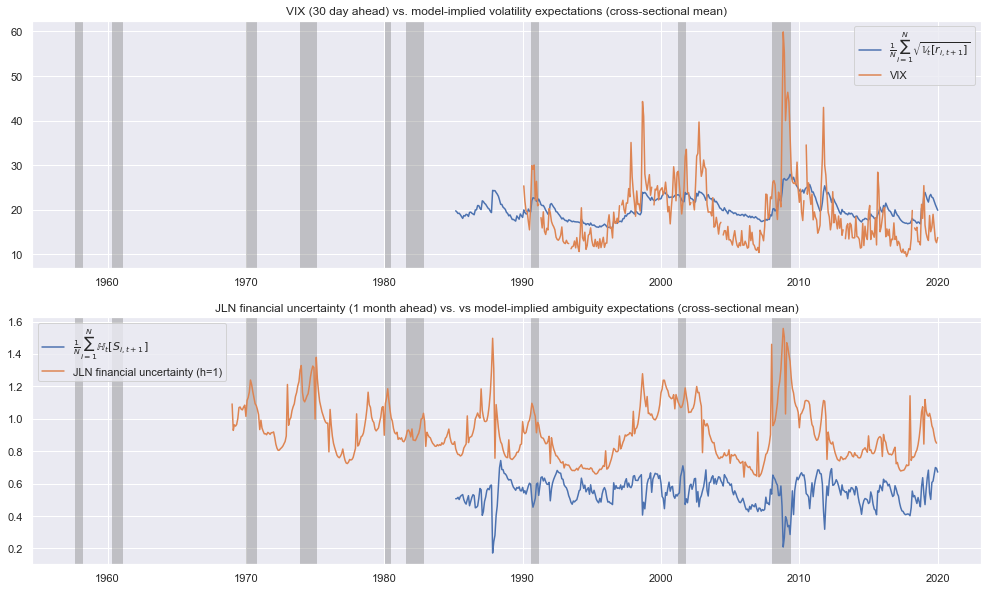

In [94]:
fig,axes = plt.subplots(2,1,figsize=[17,10])

ax = axes[0]
ax.plot(df_index_comparison[(1,'cumstd')], label='$\\frac{1}{N}\sum_{i=1}^{N}\sqrt{\mathbb{V}_t[r_{i,t+1}]}$')
ax.plot(df_index_comparison[(1,'VIX')], label='VIX')
plot.add_recession_bars(ax, startdate=df_index_comparison.index[120])
ax.legend()
ax.set_title('VIX (30 day ahead) vs. model-implied volatility expectations (cross-sectional mean)')

ax = axes[1]
ax.plot(df_index_comparison[(1,'cumentropy')], label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{H}_t[S_{i,t+1}]$')
ax.plot(df_index_comparison[(1,'JLN financial')], label='JLN financial uncertainty (h=1)')
plot.add_recession_bars(ax, startdate=df_index_comparison.index[120])
ax.legend()
ax.set_title('JLN financial uncertainty (1 month ahead) vs. vs model-implied ambiguity expectations (cross-sectional mean)')

plt.show()

#fig.savefig('indexComparisonPlots'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [95]:
# # BULLSHIT regression
# y=newframe['h=1'].diff(1).loc[newframe['h=1'].diff(1).notna()]
# x=sm.add_constant(newframe[(1, 'entropy')].diff(1).loc[newframe['h=1'].diff(1).notna()])
# sm.OLS(y,x).fit().summary()

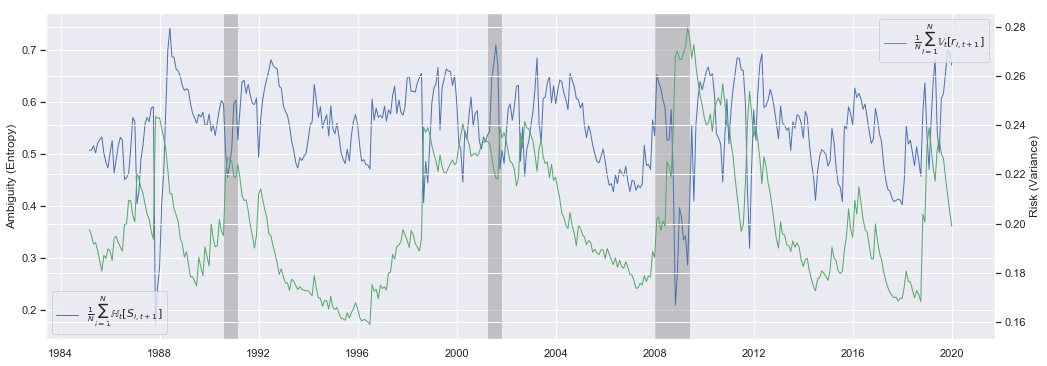

In [96]:
h=1

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots(figsize=[17,6])
ax2 = ax1.twinx()

ax1.plot(df_xs_predictions[hmm_name,h,'cumentropy'].groupby('Date').mean(), linewidth=1, color=cycle[0], alpha=1, label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{H}_t[S_{i,t+1}]$', rasterized=True)
ax1.set_ylabel('Ambiguity (Entropy)')

ax2.plot(df_xs_predictions[hmm_name,h,'cumstd'].groupby('Date').mean()*np.sqrt(12/h), linewidth=1, color=cycle[2], alpha=1, label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{V}_t[r_{i,t+1}]$', rasterized=True)
ax2.set_ylabel('Risk (Variance)')

ax1.legend(loc='lower left')
ax2.legend()

plot.add_recession_bars(ax1, startdate=df_xs_predictions.index[df_xs_predictions[hmm_name,h,'entropy'].notna()][0][0])

plt.show()

#fig.savefig('XSIndicesPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

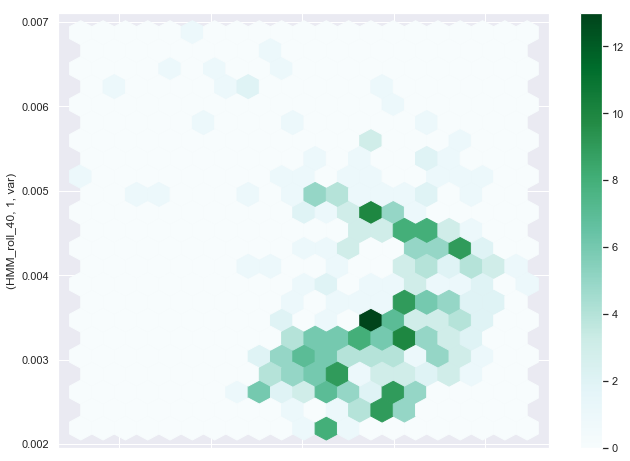

In [97]:
df_xs_predictions[[(hmm_name,h,'entropy'),(hmm_name,h,'var')]].groupby('Date').mean().plot.hexbin(x=(hmm_name,h,'entropy'), y=(hmm_name,h,'var'), gridsize=20, figsize=[11,8])
plt.show()

## Calculate

### Data Preparation

In [98]:
df_xs_reg = pd.DataFrame([], columns=pd.MultiIndex.from_product([[],[]]))

df_xs_reg[('sigma2_se',0)] = df_xs_analysis[(0,'filt_prob_0')]*df_xs_analysis[(0,'sigma2_0_se')]+df_xs_analysis[(0,'filt_prob_1')]*df_xs_analysis[(0,'sigma2_1_se')]
df_xs_reg[('rank_sigma2_se',0)] = df_xs_reg[('sigma2_se',0)].unstack().rank(axis=1, ascending=True).stack()

for h in tqdm.trange(1,13):
    df_xs_reg[('return',h)] = ((1+df_xs_estimates[('data','return')].unstack()).rolling(window=h).apply(np.prod, raw=True) - 1).stack()
    df_xs_reg[('E',h)] = df_xs_analysis[(h,'cummean')]
    df_xs_reg[('SD',h)] = df_xs_analysis[(h,'cumstd')]
    df_xs_reg[('V',h)] = df_xs_analysis[(h,'cumvar')]
    df_xs_reg[('S',h)] = df_xs_analysis[(h,'cumskew')]
    df_xs_reg[('K',h)] = df_xs_analysis[(h,'cumkurt')]
    df_xs_reg[('H',h)] = df_xs_analysis[(h,'cumentropy')]
    df_xs_reg[('rank_V',h)] = df_xs_reg[('V',h)].unstack().rank(axis=1, ascending=True).stack()
    df_xs_reg[('rank_H',h)] = df_xs_reg[('H',h)].unstack().rank(axis=1, ascending=True).stack()
    df_xs_reg[('rank_H_x_sigma2_se',h)] = df_xs_reg[('rank_H',h)]+df_xs_reg[('rank_sigma2_se',0)]

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.19it/s]


### Variable Summary Stats

In [99]:
x = df_xs_reg.iloc[:,0:11].loc[df_xs_reg[('sigma2_se',0)].notna()]

variable_names = ['$r_{i,t}$',
        #          '$\mathbb{E}_t[r_{i,t+1}]$',
                  '$\mathbb{SD}_t[r_{i,t+1}]$',
                  '$\mathbb{V}_t[r_{i,t+1}]$',
        #          '$\mathbb{S}_t[r_{i,t+1}]$',
                  '$\mathbb{K}_t[r_{i,t+1}]$',
                  '$\mathbb{H}_t[S_{i,t+1}]$',
        #          '$\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$',
                  '$\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$',
#                   '$Rank \sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$',
#                   '$Rank \sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$',
                  ]

order = [2,4,5,7,8,0]#[4,5,6,7,8,9,10,0,1]

x = x.iloc[:,order]

regressors_table = pd.DataFrame(index=['N total','N (industry)','mean','std','min','median','max','skewness','kurtosis','Jarque-Bera (p)','autocorr (1)','Durbin-Watson','Aug. Dickey-Fuller (p)','']+variable_names, columns=variable_names)

regressors_table.loc['N total',:] = x.count().values
regressors_table.loc['N (industry)',:] = x.unstack().count().unstack().mean(axis=1).values
regressors_table.loc['mean',:] = x.unstack().mean().unstack().mean(axis=1).values
regressors_table.loc['std',:] = x.unstack().std().unstack().mean(axis=1).values
regressors_table.loc['min',:] = x.unstack().min().unstack().mean(axis=1).values
regressors_table.loc['median',:] = x.unstack().median().unstack().mean(axis=1).values
regressors_table.loc['max',:] = x.unstack().max().unstack().mean(axis=1).values
regressors_table.loc['skewness',:] = x.unstack().skew().unstack().mean(axis=1).values
regressors_table.loc['kurtosis',:] = x.unstack().kurt().unstack().mean(axis=1).values

#regressors_table.loc['autocorrelation (1-12)',:] = x.apply(lambda col: sum([col.autocorr(l) for l in range(1,2)]), axis=0).values

regressors_table.loc['Jarque-Bera (p)',:] = x.unstack().apply(lambda col: sm.stats.stattools.jarque_bera(col[col.notna()])[1], axis=0).unstack().mean(axis=1).values
regressors_table.loc['autocorr (1)',:] = x.unstack().apply(lambda col: col.autocorr(1), axis=0).unstack().mean(axis=1).values
regressors_table.loc['Durbin-Watson',:] = x.unstack().apply(lambda col: sm.stats.stattools.durbin_watson(col[col.notna()])).unstack().mean(axis=1).values
regressors_table.loc['Aug. Dickey-Fuller (p)',:] = x.unstack().progress_apply(lambda col: sm.tsa.stattools.adfuller(col[col.notna()], autolag='AIC')[1]).unstack().mean(axis=1).values

regressors_table.loc[variable_names,:] = np.tril(x.iloc[:,:].corr().values)
regressors_table.loc[variable_names,:] = regressors_table.loc[variable_names,:].replace(0,'')

regressors_table = regressors_table.replace(np.nan,'')

#calc.export_df_to_latex(regressors_table, 'dataSummaryTable'+hmm_name)

regressors_table

100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [00:06<00:00, 41.81it/s]


,"$r_{i,t}$","$\mathbb{SD}_t[r_{i,t+1}]$","$\mathbb{V}_t[r_{i,t+1}]$","$\mathbb{K}_t[r_{i,t+1}]$","$\mathbb{H}_t[S_{i,t+1}]$","$\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$"
N total,19103,19103,19103,19103,19103,19103
N (industry),389.8571,389.8571,389.8571,389.8571,389.8571,389.8571
mean,0.0077,0.0591,0.0038,0.7312,0.5461,0.0020
std,0.0624,0.0114,0.0015,0.4585,0.2652,0.0242
min,-0.2775,0.0408,0.0018,0.0343,0.0733,0.0002
median,0.0105,0.0576,0.0035,0.6760,0.5171,0.0005
max,0.2510,0.0868,0.0079,1.8316,0.9998,0.4862
skewness,-0.3380,0.5063,0.7992,0.3381,0.1900,7.1585
kurtosis,3.0044,0.0377,0.6616,-0.3352,-0.9021,106.8001
Jarque-Bera (p),0.0089,0.0037,0.0006,0.0424,0.0016,0.0074


### Pooled Regressions

In [100]:
df_xs_reg.columns.tolist()[0:20]+['...']

[('sigma2_se', 0),
 ('rank_sigma2_se', 0),
 ('return', 1),
 ('E', 1),
 ('SD', 1),
 ('V', 1),
 ('S', 1),
 ('K', 1),
 ('H', 1),
 ('rank_V', 1),
 ('rank_H', 1),
 ('rank_H_x_sigma2_se', 1),
 ('return', 2),
 ('E', 2),
 ('SD', 2),
 ('V', 2),
 ('S', 2),
 ('K', 2),
 ('H', 2),
 ('rank_V', 2),
 '...']

In [101]:
index_dict = {'constant': 'constant',
              'E': '$\mathbb{E}_t[r_{i,t+1}]$',
              'SD': '$\mathbb{SD}_t[r_{i,t+1}]$',
              'V': '$\mathbb{V}_t[r_{i,t+1}]$',
              'S': '$\mathbb{S}_t[r_{i,t+1}]$',
              'K': '$\mathbb{K}_t[r_{i,t+1}]$',
              'H': '$\mathbb{H}_t[S_{i,t+1}]$',
              'rank_H': '$rank(\mathbb{H}_t[S_{i,t+1}])$',
              'mu_se': '$\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s})$',
              'sigma2_se': '$\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s})$',
              'rank_H_x_mu_se': '$rank(\mathbb{H}_t[S_{i,t+1}]) + rank(\sum_{s_t=0}^{S} P[s_t] * s.e.(\mu_{i,t,s}))$',
              'rank_H_x_sigma2_se': '$rank(\mathbb{H}_t[S_{i,t+1}]) + rank(\sum_{s_t=0}^{S} P[s_t] * s.e.(\sigma^2_{i,t,s}))$',
              'N': 'N',
              'Regression P-value': 'Regression P-value',
              'R$^2$ (model)': 'R$^2$ (model)',
             }

In [105]:
h = 1

dependent = [('return',1)]
independents = [[('H',h)],
                [('rank_H',h)],
                [('V',h)],
                [('V',h),('H',h)],
                [('rank_H',h),('V',h)],
                #[('E',1),('V',1),('S',1),('K',1),('H',1)],
                #[('E',1),('V',1),('S',1),('K',1),('rank_H',1)],
                #[('mu_se', 0),('sigma2_se', 0),('H',1)],
                #[('mu_se', 0),('sigma2_se', 0),('rank_H',1)],
                #[('rank_H_x_mu_se', 1),('H',1)],
                [('rank_H_x_sigma2_se', h),('H',h)],
               ]

row_labels = [str(i[0]) for i in calc.get_unique_values_from_list_of_lists(independents)]
y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,len(independents)+1))

col = 0
for select in independents:
    x = df_xs_reg.loc[:,select]
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit()
    
    reg_table.iloc[[0]+[row_labels.index(str(v[0]))*3+3 for v in select],col] = regf.params.values
    reg_table.iloc[[1]+[row_labels.index(str(v[0]))*3+4 for v in select],col] = regf.tstats.values
    reg_table.iloc[[2]+[row_labels.index(str(v[0]))*3+5 for v in select],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1

reg_table.index = pd.MultiIndex.from_arrays([[index_dict.get(i) for i in list(reg_table.index.get_level_values(0))],list(reg_table.index.get_level_values(1))])
    
#calc.export_df_to_latex(reg_table, 'pooledRegTable'+hmm_name)    

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1  \
constant                                           coefficient estimate  0.0096   
                                                   t-statistic           9.4348   
                                                   t-statistic (DK)      2.8593   
$\mathbb{H}_t[S_{i,t+1}]$                          coefficient estimate -0.0037   
                                                   t-statistic          -2.2405   
                                                   t-statistic (DK)     -1.0208   
$rank(\mathbb{H}_t[S_{i,t+1}])$                    coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$\mathbb{V}_t[r_{i,t+1}]$                          coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
$rank(\mathbb{H}_t[S_{i,t+1}]) + rank(\sum_{s_t... coefficient estimate           
                                                   t-statistic                    
                                                   t-statistic (DK)               
N                                                                         19054   
Regression P-value                                                       0.0251   
R$^2$ (model)                                                            0.0003   

                                                                             2  \
constant                                           coefficient estimate 0.0075   
                                                   t-statistic          8.0421   
                                                   t-statistic (DK)     3.1475   
$\mathbb{H}_t[S_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
                                                   t-statistic (DK)              
$rank(\mathbb{H}_t[S_{i,t+1}])$                    coefficient estimate 0.0000   
                                                   t-statistic          0.0828   
                                                   t-statistic (DK)     0.0799   
$\mathbb{V}_t[r_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
                                                   t-statistic (DK)              
$rank(\mathbb{H}_t[S_{i,t+1}]) + rank(\sum_{s_t... coefficient estimate          
                                                   t-statistic                   
                                                   t-statistic (DK)              
N                                                                        19054   
Regression P-value                                                      0.9340   
R$^2$ (model)                                                           0.0000   

                                                                             3  \
constant                                           coefficient estimate 0.0055   
                                                   t-statistic          6.2091   
                                                   t-statistic (DK)     2.1338   
$\mathbb{H}_t[S_{i,t+1}]$                          coefficient estimate          
                                                   t-statistic                   
                                                   t-statistic (DK)              
$rank(\mathbb{H}_t[S_{i,t+1}])$                    coefficient estimate          
                                                   t-statistic                   
                                                   t-statistic (DK)              
$\mathbb{V}_t[r_{i,t+1}]$                          coefficient estimate 0.5699   
                                       

#### Longer Horizons

In [106]:
row_labels = ['V']

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,13))

col = 0
for h in range(1,13):
    
    dependent = [('return',h)]
    y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)
    
    select = [(row_labels[0],h)]
    x = df_xs_reg.loc[:,select]
    
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit()
    
    reg_table.iloc[[0]+[3],col] = regf.params.values
    reg_table.iloc[[1]+[4],col] = regf.tstats.values
    reg_table.iloc[[2]+[5],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1 

variance_horizon_table = reg_table.copy()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

In [107]:
variance_horizon_table#.replace(np.nan,'')

1      2       3       4       5   \
constant           coefficient estimate 0.0055 0.0106  0.0163  0.0213  0.0266   
                   t-statistic          6.2091 8.2395 10.1861 11.3274 12.4588   
                   t-statistic (DK)     2.1338 2.1502  2.2737  2.2820  2.3344   
V                  coefficient estimate 0.5699 0.6493  0.6234  0.6535  0.6521   
                   t-statistic          2.7871 4.3419  5.0387  5.9973  6.5853   
                   t-statistic (DK)     0.7088 0.8776  0.8795  0.9597  1.0020   
N                                        19054  19005   18956   18907   18858   
Regression P-value                      0.0053 0.0000  0.0000  0.0000  0.0000   
R$^2$ (model)                           0.0004 0.0010  0.0013  0.0019  0.0023   

                                             6       7       8       9   \
constant           coefficient estimate  0.0319  0.0382  0.0451  0.0521   
                   t-statistic          13.4652 14.8501 16.3026 17.5955   
                   t-statistic (DK)      2.3919  2.5211  2.6771  2.8305   
V                  coefficient estimate  0.6565  0.6159  0.5664  0.5314   
                   t-statistic           7.1781  7.2407  7.0930  6.9987   
                   t-statistic (DK)      1.0592  1.0413  1.0043  0.9910   
N                                         18809   18760   18711   18662   
Regression P-value                       0.0000  0.0000  0.0000  0.0000   
R$^2$ (model)                            0.0027  0.0028  0.0027  0.0026   

                                             10      11      12  
constant           coefficient estimate  0.0582  0.0645  0.0713  
                   t-statistic          18.5014 19.4453 20.4381  
                   t-statistic (DK)      2.9318  3.0492  3.1991  
V                  coefficient estimate  0.5215  0.5084  0.4853  
                   t-statistic           7.1987  7.3400  7.2719  
                   t-statistic (DK)      1.0281  1.0666  1.0786  
N                                         18613   18564   18515  
Regression P-value                       0.0000  0.0000  0.0000  
R$^2$ (model)                            0.0028  0.0029  0.0028

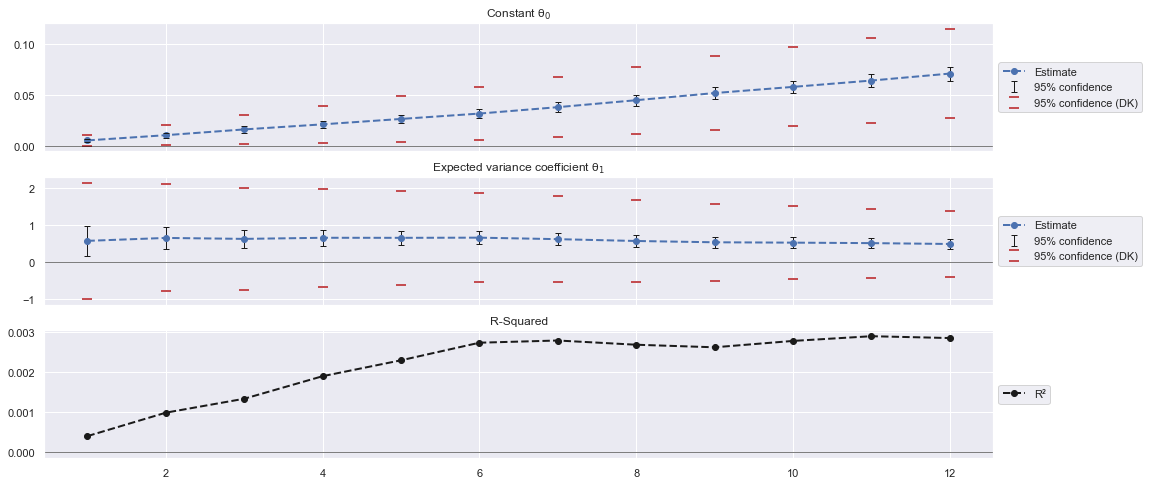

In [108]:
fig, axes = plt.subplots(3, 1, figsize=(17,8))

axes[0].plot(variance_horizon_table.T['constant','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].errorbar(range(1,13),variance_horizon_table.T['constant','coefficient estimate'],\
                 yerr=variance_horizon_table.T['constant','coefficient estimate']/variance_horizon_table.T['constant','t-statistic']*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(range(1,13),variance_horizon_table.T['constant','coefficient estimate'],\
                 yerr=variance_horizon_table.T['constant','coefficient estimate']/variance_horizon_table.T['constant','t-statistic (DK)']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (DK)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Constant θ$_0$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0].set_xticklabels([])

axes[1].plot(variance_horizon_table.T['V','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].errorbar(range(1,13),variance_horizon_table.T['V','coefficient estimate'],\
                 yerr=variance_horizon_table.T['V','coefficient estimate']/variance_horizon_table.T['V','t-statistic']*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(range(1,13),variance_horizon_table.T['V','coefficient estimate'],\
                 yerr=variance_horizon_table.T['V','coefficient estimate']/variance_horizon_table.T['V','t-statistic (DK)']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (DK)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Expected variance coefficient θ$_1$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_xticklabels([])

axes[2].plot(variance_horizon_table.T['R$^2$ (model)',''], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

#fig.savefig('varianceHorizonsPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

In [109]:
row_labels = ['H']

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,13))

col = 0
for h in range(1,13):
    
    dependent = [('return',h)]
    y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)
    
    select = [(row_labels[0],h)]
    x = df_xs_reg.loc[:,select]
    
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=False, time_effects=False)
    regf = reg.fit()
    
    reg_table.iloc[[0]+[3],col] = regf.params.values
    reg_table.iloc[[1]+[4],col] = regf.tstats.values
    reg_table.iloc[[2]+[5],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1
    
#calc.export_df_to_latex(reg_table, 'horizonRegTable')    

entropy_horizon_table = reg_table.copy()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

In [110]:
entropy_horizon_table#.replace(np.nan,'')

1       2       3       4   \
constant           coefficient estimate  0.0096  0.0206  0.0290  0.0387   
                   t-statistic           9.4348 13.0034 13.9915 15.1749   
                   t-statistic (DK)      2.8593  3.5153  3.3597  3.4688   
H                  coefficient estimate -0.0037 -0.0090 -0.0097 -0.0126   
                   t-statistic          -2.2405 -3.6048 -3.0330 -3.2567   
                   t-statistic (DK)     -1.0208 -1.4871 -1.1702 -1.2285   
N                                         19054   19005   18956   18907   
Regression P-value                       0.0251  0.0003  0.0024  0.0011   
R$^2$ (model)                            0.0003  0.0007  0.0005  0.0006   

                                             5       6       7       8   \
constant           coefficient estimate  0.0487  0.0578  0.0656  0.0731   
                   t-statistic          16.1109 16.6333 16.7982 16.8872   
                   t-statistic (DK)      3.7615  3.9827  4.0811  4.1794   
H                  coefficient estimate -0.0158 -0.0175 -0.0172 -0.0165   
                   t-statistic          -3.5120 -3.4379 -3.0580 -2.6874   
                   t-statistic (DK)     -1.4096 -1.4081 -1.2280 -1.0449   
N                                         18858   18809   18760   18711   
Regression P-value                       0.0004  0.0006  0.0022  0.0072   
R$^2$ (model)                            0.0007  0.0006  0.0005  0.0004   

                                             9       10      11      12  
constant           coefficient estimate  0.0788  0.0857  0.0932  0.0996  
                   t-statistic          16.5148 16.4699 16.5742 16.4400  
                   t-statistic (DK)      4.2188  4.2978  4.3861  4.3925  
H                  coefficient estimate -0.0128 -0.0114 -0.0108 -0.0088  
                   t-statistic          -1.9151 -1.5789 -1.4056 -1.0628  
                   t-statistic (DK)     -0.7312 -0.5857 -0.5081 -0.3780  
N                                         18662   18613   18564   18515  
Regression P-value                       0.0555  0.1144  0.1599  0.2879  
R$^2$ (model)                            0.0002  0.0001  0.0001  0.0001

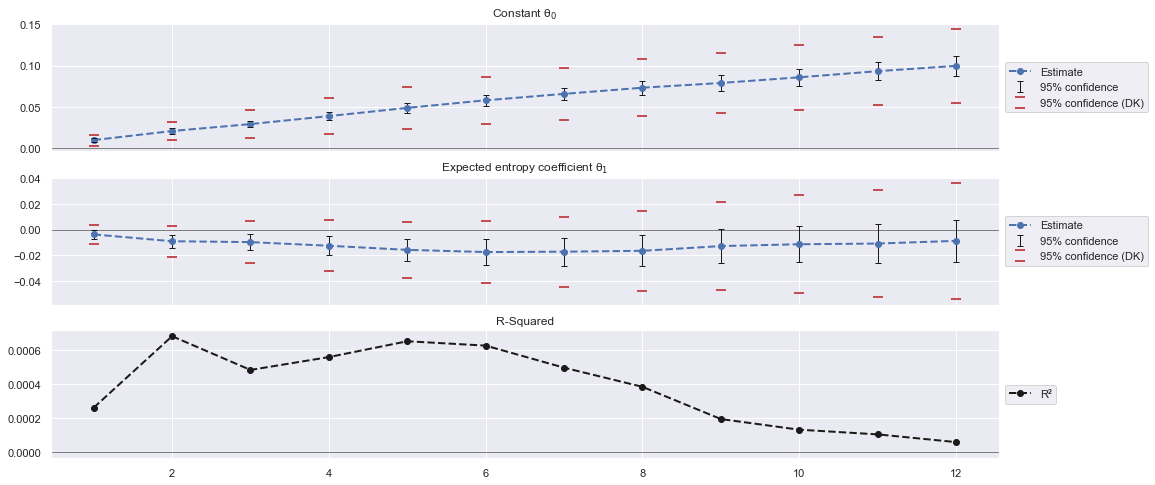

In [111]:
fig, axes = plt.subplots(3, 1, figsize=(17,8))

axes[0].plot(entropy_horizon_table.T['constant','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[0].errorbar(range(1,13),entropy_horizon_table.T['constant','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['constant','coefficient estimate']/entropy_horizon_table.T['constant','t-statistic']*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[0].errorbar(range(1,13),entropy_horizon_table.T['constant','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['constant','coefficient estimate']/entropy_horizon_table.T['constant','t-statistic (DK)']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (DK)')
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[0].set_title('Constant θ$_0$')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0].set_xticklabels([])

axes[1].plot(entropy_horizon_table.T['H','coefficient estimate'], linewidth=2, label='Estimate', linestyle='--', marker='o')
axes[1].errorbar(range(1,13),entropy_horizon_table.T['H','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['H','coefficient estimate']/entropy_horizon_table.T['H','t-statistic']*1.96,
                 fmt='none', color='k', linewidth=1, capsize=3, label='95% confidence')
axes[1].errorbar(range(1,13),entropy_horizon_table.T['H','coefficient estimate'],\
                 yerr=entropy_horizon_table.T['H','coefficient estimate']/entropy_horizon_table.T['H','t-statistic (DK)']*1.96,
                 fmt='none', color='r', linewidth=0, capsize=5, markeredgewidth=2, label='95% confidence (DK)')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[1].set_title('Expected entropy coefficient θ$_1$')
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[1].set_xticklabels([])

axes[2].plot(entropy_horizon_table.T['R$^2$ (model)',''], linewidth=2, linestyle='--', marker='o', color='k', label='R²')
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='-')
axes[2].set_title('R-Squared')
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(hspace=0.2)

#fig.savefig('entropyHorizonsPlot'+hmm_name+'.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

### Panel Regressions

In [52]:
index_dict.update({'time FE': 'time FE',
                   'industry FE': 'industry FE',
                   'R$^2$ (inclusive)': 'R$^2$ (inclusive)',
                  })


In [89]:
h = 12

dependent = [('return',1)]
independents = [[('H',h)],
#                 [('rank_H',1)],
#                 [('V',1)],
                [('V',h),('H',h)],
#                 [('rank_H',1),('V',1)],
#                 [('E',1),('V',1),('S',1),('K',1),('H',1)],
#                 [('E',1),('V',1),('S',1),('K',1),('rank_H',1)],
#                 [('mu_se', 0),('sigma2_se', 0),('H',1)],
#                 [('mu_se', 0),('sigma2_se', 0),('rank_H',1)],
#                 [('rank_H_x_mu_se', 1),('H',1)],
#                 [('rank_H_x_sigma2_se', 1),('H',1)],
               ]

row_labels = [str(i[0]) for i in calc.get_unique_values_from_list_of_lists(independents)]
y = df_xs_reg.loc[:,dependent].groupby('Industry').shift(-h)

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+row_labels,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,len(independents)*4+1))

col = 0
for select in independents:
    x = df_xs_reg.loc[:,select]
    
    for (ent,tim) in [(False,False),(True,False),(False,True),(True,True)]:
        reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1)), entity_effects=ent, time_effects=tim)
        regf = reg.fit()
    
        reg_table.iloc[[0]+[row_labels.index(str(v[0]))*3+3 for v in select],col] = regf.params.values
        reg_table.iloc[[1]+[row_labels.index(str(v[0]))*3+4 for v in select],col] = regf.tstats.values
        reg_table.iloc[[2]+[row_labels.index(str(v[0]))*3+5 for v in select],col] = reg.fit(cov_type='kernel').tstats.values
        reg_table.loc['time FE',col+1] = tim
        reg_table.loc['industry FE',col+1] = ent
        reg_table.loc['N',col+1] = int(regf.nobs)
        reg_table.loc['Regression P-value',col+1] = regf.f_statistic.pval
        reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
        reg_table.loc['R$^2$ (inclusive)',col+1] = regf.rsquared_inclusive
    
        col += 1

reg_table.index = pd.MultiIndex.from_arrays([[index_dict.get(i) for i in list(reg_table.index.get_level_values(0))],list(reg_table.index.get_level_values(1))])        
        
#calc.export_df_to_latex(reg_table, 'panelRegTable'+hmm_name)

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1      2      3      4  \
constant                  coefficient estimate 0.0044 0.0031 0.0060 0.0057   
                          t-statistic          3.5154 2.0041 6.7911 5.0933   
                          t-statistic (DK)     1.7480 0.9816 7.3264 4.6717   
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate 0.0042 0.0061 0.0017 0.0022   
                          t-statistic          2.3704 2.7381 1.3644 1.3919   
                          t-statistic (DK)     1.8857 1.7671 1.3941 1.2342   
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate                               
                          t-statistic                                        
                          t-statistic (DK)                                   
NaN                                             False  False   True   True   
                                                False   True  False   True   
N                                               24395  24395  24395  24395   
Regression P-value                             0.0178 0.0062 0.1724 0.1640   
R$^2$ (model)                                  0.0002 0.0003 0.0001 0.0001   
NaN                                            0.0002 0.0010 0.5230 0.5237   

                                                    5      6       7      8  
constant                  coefficient estimate 0.0043 0.0025  0.0061 0.0047  
                          t-statistic          3.1852 1.4557  6.1382 3.6586  
                          t-statistic (DK)     1.5333 0.6110  4.4695 2.4755  
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate 0.0041 0.0057  0.0017 0.0018  
                          t-statistic          2.3542 2.5090  1.3712 1.1294  
                          t-statistic (DK)     1.9548 1.8194  1.3848 0.9904  
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate 0.0008 0.0184 -0.0016 0.0263  
                          t-statistic          0.0565 0.8927 -0.1510 1.6074  
                          t-statistic (DK)     0.0258 0.3497 -0.0613 0.7397  
NaN                                             False  False    True   True  
                                                False   True   False   True  
N                                               24395  24395   24395  24395  
Regression P-value                             0.0602 0.0158  0.3898 0.1043  
R$^2$ (model)                                  0.0002 0.0003  0.0001 0.0002  
NaN                                            0.0002 0.0010  0.5230 0.5237

### Portfolio Sorts

#### Single Sorts

In [89]:
n_portfolios = 5

In [90]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('V',1)]
x2 = df_xs_reg[('H',1)]

In [91]:
single_sorts_table = pd.DataFrame()

for x in [x1,x2]:
    # sort
    portfolio_returns, portfolio_assets, portfolio_mapping = calc.sort_portfolios(y.unstack(),x.unstack(),n_portfolios,return_assets=True)
    
    # spreading returns
    portfolio_returns['5-1'] = portfolio_returns[n_portfolios]-portfolio_returns[1]
    
    # output table
    sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
    sorted_portfolios['mean'] = portfolio_returns.mean()
    sorted_portfolios['std'] = portfolio_returns.std()
    sorted_portfolios['T'] = portfolio_returns.count()
    sorted_portfolios['average N'] = portfolio_assets[portfolio_assets>0].mean()
    sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['T']**0.5)
    sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*12
    sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (12**0.5)
    sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']
    sorted_portfolios.replace(np.nan,'')
    sorted_portfolios.index = pd.MultiIndex.from_product([[x.name],['low']+list(sorted_portfolios.index)[1:-2]+['high','high-low']])
    
    # combine
    single_sorts_table = single_sorts_table.append(sorted_portfolios)
    #single_sorts_table.index = single_sorts_table.index+pd.MultiIndex.from_tuples([("","")])
    single_sorts_table = single_sorts_table.append(pd.Series(name=("","")))
    
single_sorts_table = single_sorts_table.iloc[:-1]
single_sorts_table.index.set_levels(['$\mathbb{H}_t[r_{i,t+1}]$','$\mathbb{V}_t[S_{i,t+1}]$',''],level=0,inplace=True)

single_sorts_table.replace(np.nan,'')
single_sorts_table[single_sorts_table.isna()] = ''

calc.export_df_to_latex(single_sorts_table,'singleSortsTable'+hmm_name)

single_sorts_table

mean    std        T average N  t-stat  \
$\mathbb{V}_t[S_{i,t+1}]$ low       0.0071 0.0391 637.0000    9.1900  4.6054   
                          2         0.0068 0.0475 637.0000    8.5495  3.6166   
                          3         0.0064 0.0507 637.0000    9.0377  3.1909   
                          4         0.0053 0.0544 637.0000    8.5495  2.4509   
                          high      0.0055 0.0623 637.0000    9.1900  2.2388   
                          high-low -0.0016 0.0362 637.0000           -1.1217   
                                                                               
$\mathbb{H}_t[r_{i,t+1}]$ low       0.0061 0.0531 637.0000    9.1900  2.8869   
                          2         0.0069 0.0503 637.0000    8.5495  3.4763   
                          3         0.0061 0.0492 637.0000    9.0377  3.1089   
                          4         0.0058 0.0495 637.0000    8.5495  2.9698   
                          high      0.0062 0.0507 637.0000    9.1900  3.1038   
                          high-low  0.0002 0.0239 637.0000            0.1727   

                                   return p.a. volatility p.a.      SR  
$\mathbb{V}_t[S_{i,t+1}]$ low           0.0856          0.1355  0.6321  
                          2             0.0817          0.1645  0.4964  
                          3             0.0769          0.1757  0.4380  
                          4             0.0634          0.1885  0.3364  
                          high          0.0663          0.2159  0.3073  
                          high-low     -0.0193          0.1253 -0.1540  
                                                                        
$\mathbb{H}_t[r_{i,t+1}]$ low           0.0729          0.1839  0.3962  
                          2             0.0831          0.1741  0.4771  
                          3             0.0727          0.1704  0.4267  
                          4             0.0699          0.1716  0.4076  
                          high          0.0748          0.1756  0.4260  
                          high-low      0.0020          0.0829  0.0237

#### Simultaneous Double Sorts

In [92]:
n_portfolios_1 = 3
n_portfolios_2 = 3

In [93]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('V',1)]
x2 = df_xs_reg[('H',1)]

In [94]:
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = calc.double_sort_portfolios_simultaneously(y.unstack(), x1.unstack(), x2.unstack(), n_portfolios_1 ,n_portfolios_2, return_assets=True)

double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']

sim_double_sorts_table = pd.DataFrame(index = double_portfolio_returns.columns)
sim_double_sorts_table['mean'] = double_portfolio_returns.mean()
sim_double_sorts_table['std'] = double_portfolio_returns.std()
sim_double_sorts_table['T'] = double_portfolio_returns.count()
sim_double_sorts_table['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
sim_double_sorts_table['t-stat'] = sim_double_sorts_table['mean']/(sim_double_sorts_table['std']/sim_double_sorts_table['T']**0.5)
sim_double_sorts_table['return p.a.'] = sim_double_sorts_table['mean']*12
sim_double_sorts_table['volatility p.a.'] = sim_double_sorts_table['std'] * (12**0.5)
sim_double_sorts_table['SR'] = sim_double_sorts_table['return p.a.']/sim_double_sorts_table['volatility p.a.']

sim_double_sorts_table.index = ['low,low']+list(sim_double_sorts_table.index)[1:-4]+['high,high','low,high-low,low','mid,high-mid,low','high,high-high,low']
sim_double_sorts_table = sim_double_sorts_table.rename_axis('$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$', axis=0)

sim_double_sorts_table.replace(np.nan,'')
sim_double_sorts_table[sim_double_sorts_table.isna()] = ''

calc.export_df_to_latex(sim_double_sorts_table,'simultaneousSortsTable'+hmm_name)

sim_double_sorts_table

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$",,,,,,,,
"low,low",0.0075,0.0449,637,4.7677,4.2189,0.0902,0.1557,0.5791
"1,2",0.0073,0.0416,637,5.9576,4.4091,0.0873,0.1443,0.6052
"1,3",0.0062,0.0434,632,3.8924,3.6026,0.0746,0.1502,0.4964
"2,1",0.0060,0.0531,636,4.9465,2.8314,0.0715,0.1839,0.3889
"2,2",0.0056,0.0529,636,5.1085,2.6870,0.0676,0.1832,0.3691
"2,3",0.0069,0.0523,636,5.3113,3.3232,0.0827,0.1811,0.4565
"3,1",0.0060,0.0653,636,4.8884,2.3050,0.0716,0.2261,0.3166
"3,2",0.0044,0.0629,630,4.3317,1.7433,0.0524,0.2180,0.2406
"high,high",0.0052,0.0600,637,5.4223,2.2063,0.0630,0.2080,0.3028


#### Sequential Double Sorts

In [95]:
n_portfolios_1 = 3
n_portfolios_2 = 3

In [96]:
y = df_xs_reg[('return',1)]
x1 = df_xs_reg[('V',1)]
x2 = df_xs_reg[('H',1)]

In [ ]:
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = calc.double_sort_portfolios(y.unstack(), x1.unstack(), x2.unstack(), n_portfolios_1 ,n_portfolios_2, return_assets=True)

double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']

seq_double_sorts_table = pd.DataFrame(index = double_portfolio_returns.columns)
seq_double_sorts_table['mean'] = double_portfolio_returns.mean()
seq_double_sorts_table['std'] = double_portfolio_returns.std()
seq_double_sorts_table['T'] = double_portfolio_returns.count()
seq_double_sorts_table['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
seq_double_sorts_table['t-stat'] = seq_double_sorts_table['mean']/(seq_double_sorts_table['std']/seq_double_sorts_table['T']**0.5)
seq_double_sorts_table['return p.a.'] = seq_double_sorts_table['mean']*12
seq_double_sorts_table['volatility p.a.'] = seq_double_sorts_table['std'] * (12**0.5)
seq_double_sorts_table['SR'] = seq_double_sorts_table['return p.a.']/seq_double_sorts_table['volatility p.a.']

seq_double_sorts_table.index = ['low,low']+list(seq_double_sorts_table.index)[1:-4]+['high,high','low,high-low,low','mid,high-mid,low','high,high-high,low']
seq_double_sorts_table = seq_double_sorts_table.rename_axis('$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$', axis=0)

seq_double_sorts_table.replace(np.nan,'')
seq_double_sorts_table[seq_double_sorts_table.isna()] = ''

calc.export_df_to_latex(seq_double_sorts_table,'sequentialSortsTable'+hmm_name)

seq_double_sorts_table